In [1]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

In [2]:
datafile='data7.parquet'


### IP geolocalization


In [3]:

gi=pygeoip.GeoIP('./GeoIP.dat')
gi2=pygeoip.GeoIP('./GeoIPASNum.dat')
addr='193.136.73.21'
cc=gi.country_code_by_addr(addr)
org=gi2.org_by_addr(addr)
print(cc,org)

PT AS1930 Fundacao para a Ciencia e a Tecnologia, I.P.


### DNS resolution


In [4]:

addr=dns.resolver.resolve("www.ua.pt", 'A')
for a in addr:
    print(a)

193.136.173.58


### Reverse DNS resolution    


In [5]:

name=dns.reversename.from_address("193.136.172.20")
addr=dns.resolver.resolve(name, 'PTR')
for a in addr:
    print(a)

dns.ua.pt.


### Read parquet data files


In [6]:

data=pd.read_parquet(datafile)
#print(data.to_string())


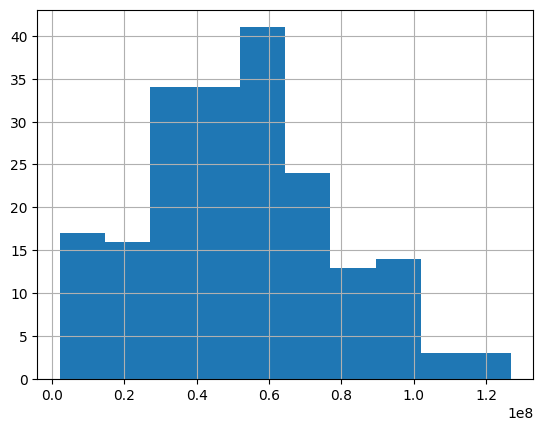

src_ip
192.168.107.162    1462.882468
192.168.107.191    1425.918122
192.168.107.67     1405.497691
192.168.107.108    1387.474215
192.168.107.106    1336.097690
                      ...     
192.168.107.20      403.691304
192.168.107.204     397.780341
192.168.107.114     391.994024
192.168.107.143     378.927885
192.168.107.81      319.656616
Name: diff_timestamp, Length: 199, dtype: float64

In [7]:

#Just the UDP flows
udpF=data.loc[data['proto']=='udp']

#Number of UDP flows for each source IP
nudpF=data.loc[data['proto']=='udp'].groupby(['src_ip'])['up_bytes'].count()

#Number of UDP flows to port 443, for each source IP
nudpF443=data.loc[(data['proto']=='udp')&(data['port']==443)].groupby(['src_ip'])['up_bytes'].count()

#Average number of downloaded bytes, per flow, for each source IP
avgUp=data.groupby(['src_ip'])['down_bytes'].mean()


#Total uploaded bytes to destination port 443, for each source IP, ordered from larger amount to lowest amount
upS=data.loc[((data['port']==443))].groupby(['src_ip'])['up_bytes'].sum().sort_values(ascending=False)

#Histogram of the total uploaded bytes to destination port 443, by source IP
upS=data.loc[((data['port']==443))].groupby(['src_ip'])['up_bytes'].sum().hist()
plt.show()

#Upload/Download bytes ratio (traffic for port 443) for each source IP
a1=data.loc[((data['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
a2=data.loc[((data['port']==443))].groupby(['src_ip'])['down_bytes'].sum()
a3=pd.DataFrame(a2/a1,columns=['ratio'])

#Is destination IPv4 a public address?
NET=ipaddress.IPv4Network('192.168.100.0/24')
bpublic=data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)

#Geolocalization of public destination adddress
cc=data[bpublic]['dst_ip'].apply(lambda y:gi.country_code_by_addr(y)).to_frame(name='cc')

#Average interval between flows from same source IP (for each source IP)
data['diff_timestamp']=data.groupby(['src_ip'])['timestamp'].diff().fillna(0)
data.groupby(['src_ip'])['diff_timestamp'].mean().sort_values(ascending=False)
